In [3]:
import sys
sys.path.append('../../../patronus/')
from global_config import * # load REPO_HOME_DIR, DATASET_DIR

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Basic analysis and dataset construction for diagnosis exeperiment
In this work, we manipulate a bias dataset of CelebA by selecting: blonde/brown hair is always smiling, and black hair is always non-smiling.

In [5]:
meta_file_celeba = f'{DATASET_DIR}/CelebA/Anno/metadata.csv'
meta_celeba = pd.read_csv(meta_file_celeba)
meta_celeba.head(5)

,img_filename,split,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


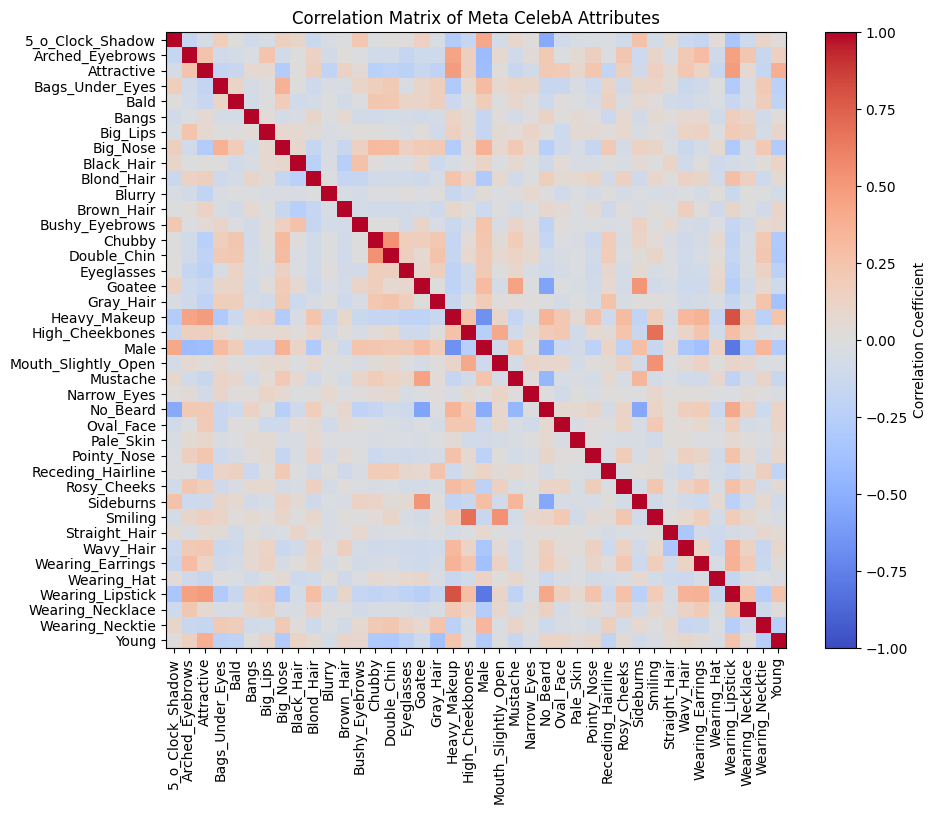

In [7]:
# get the correlation between the attributes
columns_to_remove = ['split', ]  # Replace with the columns you want to drop
filtered_data = meta_celeba.drop(columns=columns_to_remove)
correlation = filtered_data.corr()
# plot 
# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='none', aspect='auto',vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(correlation.shape[1]), correlation.columns, rotation=90)
plt.yticks(range(correlation.shape[0]), correlation.index)
plt.title('Correlation Matrix of Meta CelebA Attributes')
plt.show()

Here we can also observe some existing unwanted correlation inside the CelebA dataset. 

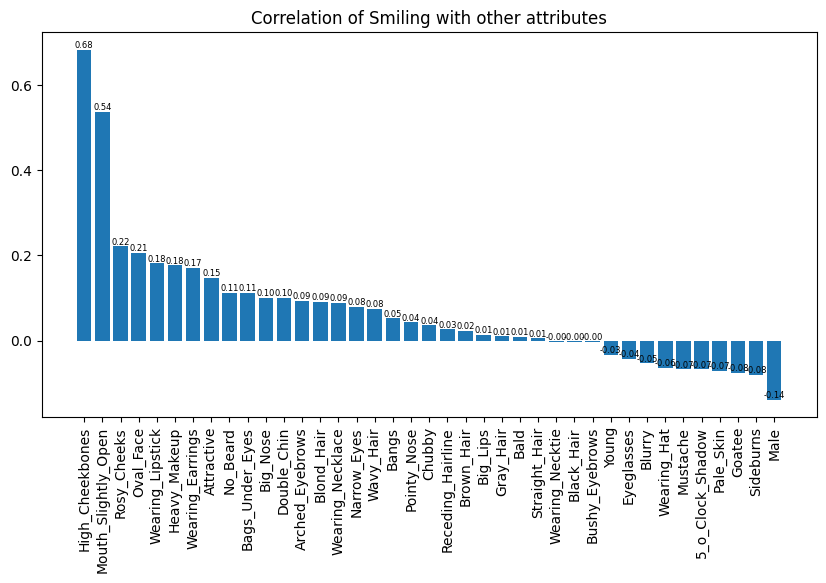

In [9]:
# get the correlation of one given attribute and all others
attribute = 'Smiling'
correlatio_s = filtered_data.corr()[attribute]
correlatio_s = correlatio_s.drop(attribute)
correlatio_s = correlatio_s.sort_values(ascending=False)
# print(correlation)

# plot the correlation of one given attribute and all others
plt.figure(figsize=(10, 5))
plt.bar(correlatio_s.index, correlatio_s)
plt.xticks(rotation=90)
plt.title(f'Correlation of {attribute} with other attributes')
# show the value of the correlation
for i, v in enumerate(correlatio_s):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=6)

# tilt the x-axis labels
plt.xticks(rotation=90,ha='center')
plt.show()


By listing the correlation between "smile" and other attributes, we can see that it's negatively related to male, highly positively related to high cheekbones.  
And interestingly, positively related to blonde hair.

In [10]:
print('all hair related attributes:')
# print out all that have hair
hair = [col for col in meta_celeba.columns if 'Hair' in col]
print(hair)

all hair related attributes:
['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair']


There are some data that have both 'xx_Hair' and 'xx_Hair' == 1 at the same time. we will filter out this part of data.

In [11]:
hair_attr =  ['Black_Hair', 'Blond_Hair','Brown_Hair']#, 'Gray_Hair']
filtered_df = meta_celeba[meta_celeba[hair_attr].eq(1).sum(axis=1) ==1] # only the samples has one and only one of the hair color == 1 is included
# print(filtered_df.shape)
print(f'{filtered_df.shape=}')
print(f'{meta_celeba.shape=}')

filtered_df.shape=(115309, 42)
meta_celeba.shape=(202599, 42)


 And we select: </br>
1. blond/brown and smile 
2. balck and non-smile

In [12]:
blonde_smlie = filtered_df[(filtered_df['Blond_Hair'] == 1) & (filtered_df['Smiling'] == 1)]
print(f'{blonde_smlie.shape=}')
balck_nonsmlie = filtered_df[(filtered_df['Black_Hair'] == 1) & (filtered_df['Smiling'] == -1)]
print(f'{balck_nonsmlie.shape=}')
brown_smlie = filtered_df[(filtered_df['Brown_Hair'] == 1) & (filtered_df['Smiling'] == 1)]
print(f'{brown_smlie.shape=}')

blonde_smlie.shape=(16916, 42)
balck_nonsmlie.shape=(24680, 42)
brown_smlie.shape=(19618, 42)


In [13]:
# cat all the dataframes
final_df = pd.concat([blonde_smlie, balck_nonsmlie, brown_smlie])
print(f'{final_df.shape=}')
final_df[['img_filename','Smiling']+hair_attr].head(5)

final_df.shape=(61214, 42)


,img_filename,Smiling,Black_Hair,Blond_Hair,Brown_Hair
12,000013.jpg,1,-1,1,-1
17,000018.jpg,1,-1,1,-1
28,000029.jpg,1,-1,1,-1
53,000054.jpg,1,-1,1,-1
70,000071.jpg,1,-1,1,-1


In [14]:
correlation = final_df.corr()
print(correlation['Smiling'][hair_attr])

Black_Hair   -1.000000
Blond_Hair    0.507903
Brown_Hair    0.564450
Name: Smiling, dtype: float64


In [ ]:
# save this meta data
final_df.to_csv(f'{DATASET_DIR}/CelebA/Anno/metadata_m_hair_smile.csv', index=False)

After having this, train Patronus with this subset of data by setting `ds_name` in `train_config.py` to `CelebA_hair_smile`.